In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot as plt

# nome para salvar as figuras
n = str(10)
figname = 'multi3-' + n

# carregar e preparar o dataset
dataset = read_csv('df_unificado.csv', index_col=0)

# filtrar a partir da data escolhida na etapa de exploração
filtro = (dataset.index>='2016-07-01')
dataset = dataset.loc[filtro]

dataset.index.name = 'Data'

# remover colunas que não serão utilizadas
dataset.drop('Unique_Addresses', axis=1, inplace=True)
dataset.drop('Transactions', axis=1, inplace=True)
dataset.drop('Volume', axis=1, inplace=True)

# sumário do dataset
print(dataset)

               Price_USD     Marketcap    Difficulty  Total_Bitcoins
Data                                                                
2016-07-01    672.515015  1.063267e+10  2.094532e+11     15721925.00
2016-07-02    676.734009  1.106617e+10  2.094532e+11     15725650.00
2016-07-03    704.968018  1.036046e+10  2.094532e+11     15728550.00
2016-07-04    658.804016  1.075623e+10  2.095577e+11     15733275.00
2016-07-05    683.208984  1.055359e+10  2.133989e+11     15736900.00
...                  ...           ...           ...             ...
2021-07-02  33549.600177  6.354508e+11  1.993279e+13     18746512.50
2021-07-03  33854.421362  6.499397e+11  1.563486e+13     18747300.00
2021-07-04  34665.564866  6.615748e+11  1.436303e+13     18748031.25
2021-07-05  35284.344430  6.326962e+11  1.436303e+13     18748831.25
2021-07-06  33723.509655  6.418992e+11  1.436303e+13     18749743.75

[1832 rows x 4 columns]


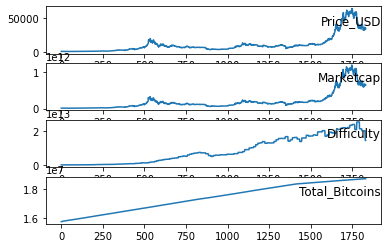

In [2]:
# preparar dataset
valores = dataset.values

# especificar colunas para plotar
colunas = [0, 1, 2, 3]
i = 1

# plotar cada coluna
plt.figure()
for coluna in colunas:
    plt.subplot(len(colunas), 1, i)
    plt.plot(valores[:, coluna])
    plt.title(dataset.columns[coluna], y=0.5, loc='right')
    i += 1
plt.show()

In [3]:
# função conversora de série para aprendizado supervisionado
def serie_para_supervisionado(dados, n_in=1, n_out=1, dropnulos=True):
    n_vars = 1 if type(dados) is list else dados.shape[1]
    df = DataFrame(dados)
    cols, nomes = list(), list()
    # sequência de inputs (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    nomes += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # sequência de previsões (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            nomes += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            nomes += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # juntar tudo
    retorno = concat(cols, axis=1)
    retorno.columns = nomes
    # remover linhas com valores nulos
    if dropnulos:
        retorno.dropna(inplace=True)
    return retorno

# garantir que todos os dados são float
valores = valores.astype('float32')

# normalizar variáveis
normalizador = MinMaxScaler(feature_range=(0, 1))
valores_normalizados = normalizador.fit_transform(valores)

# reestruturar para aprendizado supervisionado
reestruturado = serie_para_supervisionado(valores_normalizados, 1, 1)

# remover colunas que não desejamos prever
print(reestruturado)
reestruturado.drop(reestruturado.columns[[5,6,7]], axis=1, inplace=True)
print(reestruturado)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)  \
1      0.001967   0.001688   0.000304   0.000000  0.002034  0.002056   
2      0.002034   0.002056   0.000304   0.001230  0.002482  0.001457   
3      0.002482   0.001457   0.000304   0.002188  0.001749  0.001793   
4      0.001749   0.001793   0.000308   0.003748  0.002137  0.001621   
5      0.002137   0.001621   0.000463   0.004946  0.001933  0.001712   
...         ...        ...        ...        ...       ...       ...   
1827   0.547634   0.527031   0.794173   0.998690  0.524032  0.532220   
1828   0.524032   0.532220   0.794173   0.998932  0.528872  0.544523   
1829   0.528872   0.544523   0.621180   0.999193  0.541752  0.554402   
1830   0.541752   0.554402   0.569988   0.999434  0.551578  0.529881   
1831   0.551578   0.529881   0.569988   0.999699  0.526793  0.537696   

       var3(t)   var4(t)  
1     0.000304  0.001230  
2     0.000304  0.002188  
3     0.000308  0.003748  
4     0.000463  0.004946  


In [4]:
# separar em sets de treino e de teste
valores = reestruturado.values
n_dias_treinamento = len(valores) - 217
treino = valores[:n_dias_treinamento, :]
teste = valores[n_dias_treinamento:, :]

# separar em inputs e outputs
treino_X, treino_y = treino[:, :-1], treino[:, -1]
teste_X, teste_y = teste[:, :-1], teste[:, -1]

# reestruturar para 3D [samples, timesteps, features]
treino_X = treino_X.reshape((treino_X.shape[0], 1, treino_X.shape[1]))
teste_X = teste_X.reshape((teste_X.shape[0], 1, teste_X.shape[1]))
print(treino_X.shape, treino_y.shape, teste_X.shape, teste_y.shape)

(1614, 1, 4) (1614,) (217, 1, 4) (217,)


In [5]:
# preparar a rede neural
modelo = Sequential()
modelo.add(LSTM(30, input_shape=(treino_X.shape[1], treino_X.shape[2])))
modelo.add(Dropout(0.3))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

callback_treinamento = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

# treinar o modelo
historico = modelo.fit(treino_X, treino_y, epochs=300, batch_size=32, validation_data=(teste_X, teste_y), verbose=2, shuffle=False, callbacks=[callback_treinamento])

Epoch 1/300
51/51 - 1s - loss: 0.0030 - val_loss: 0.2506
Epoch 2/300
51/51 - 0s - loss: 0.0026 - val_loss: 0.2208
Epoch 3/300
51/51 - 0s - loss: 0.0024 - val_loss: 0.2005
Epoch 4/300
51/51 - 0s - loss: 0.0022 - val_loss: 0.1804
Epoch 5/300
51/51 - 0s - loss: 0.0020 - val_loss: 0.1577
Epoch 6/300
51/51 - 0s - loss: 0.0018 - val_loss: 0.1404
Epoch 7/300
51/51 - 0s - loss: 0.0017 - val_loss: 0.1204
Epoch 8/300
51/51 - 0s - loss: 0.0014 - val_loss: 0.1013
Epoch 9/300
51/51 - 0s - loss: 0.0014 - val_loss: 0.0834
Epoch 10/300
51/51 - 0s - loss: 0.0012 - val_loss: 0.0622
Epoch 11/300
51/51 - 0s - loss: 9.7533e-04 - val_loss: 0.0469
Epoch 12/300
51/51 - 0s - loss: 8.7063e-04 - val_loss: 0.0319
Epoch 13/300
51/51 - 0s - loss: 7.0999e-04 - val_loss: 0.0179
Epoch 14/300
51/51 - 0s - loss: 6.0690e-04 - val_loss: 0.0094
Epoch 15/300
51/51 - 0s - loss: 4.8647e-04 - val_loss: 0.0036
Epoch 16/300
51/51 - 0s - loss: 3.8551e-04 - val_loss: 9.1917e-04
Epoch 17/300
51/51 - 0s - loss: 3.4294e-04 - val_loss

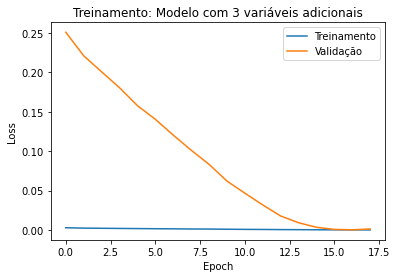

In [6]:
# plotar histórico de treinamento
plt.title('Treinamento: Modelo com 3 variáveis adicionais')
plt.plot(historico.history['loss'], label='Treinamento')
plt.plot(historico.history['val_loss'], label='Validação')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(figname+'-train.png', bbox_inches='tight')
plt.show()

In [7]:
# fazer a previsão
previsao = modelo.predict(teste_X)
teste_X = teste_X.reshape((teste_X.shape[0], teste_X.shape[2]))

# desfazer a normalização dos valores da previsão
previsao_reescala = concatenate((previsao, teste_X[:, 1:]), axis=1)
previsao_reescala = normalizador.inverse_transform(previsao_reescala)
previsao_reescala_rmse = previsao_reescala[:,0]

# desfazer a normalização dos valores reais
teste_y = teste_y.reshape((len(teste_y), 1))
teste_reescala = concatenate((teste_y, teste_X[:, 1:]), axis=1)
teste_reescala = normalizador.inverse_transform(teste_reescala)
teste_reescala_rmse = teste_reescala[:,0]

# calcular RMSE
rmse = sqrt(mean_squared_error(teste_reescala_rmse, previsao_reescala_rmse))
print('Teste RMSE: %.3f' % rmse)

Teste RMSE: 2433.182


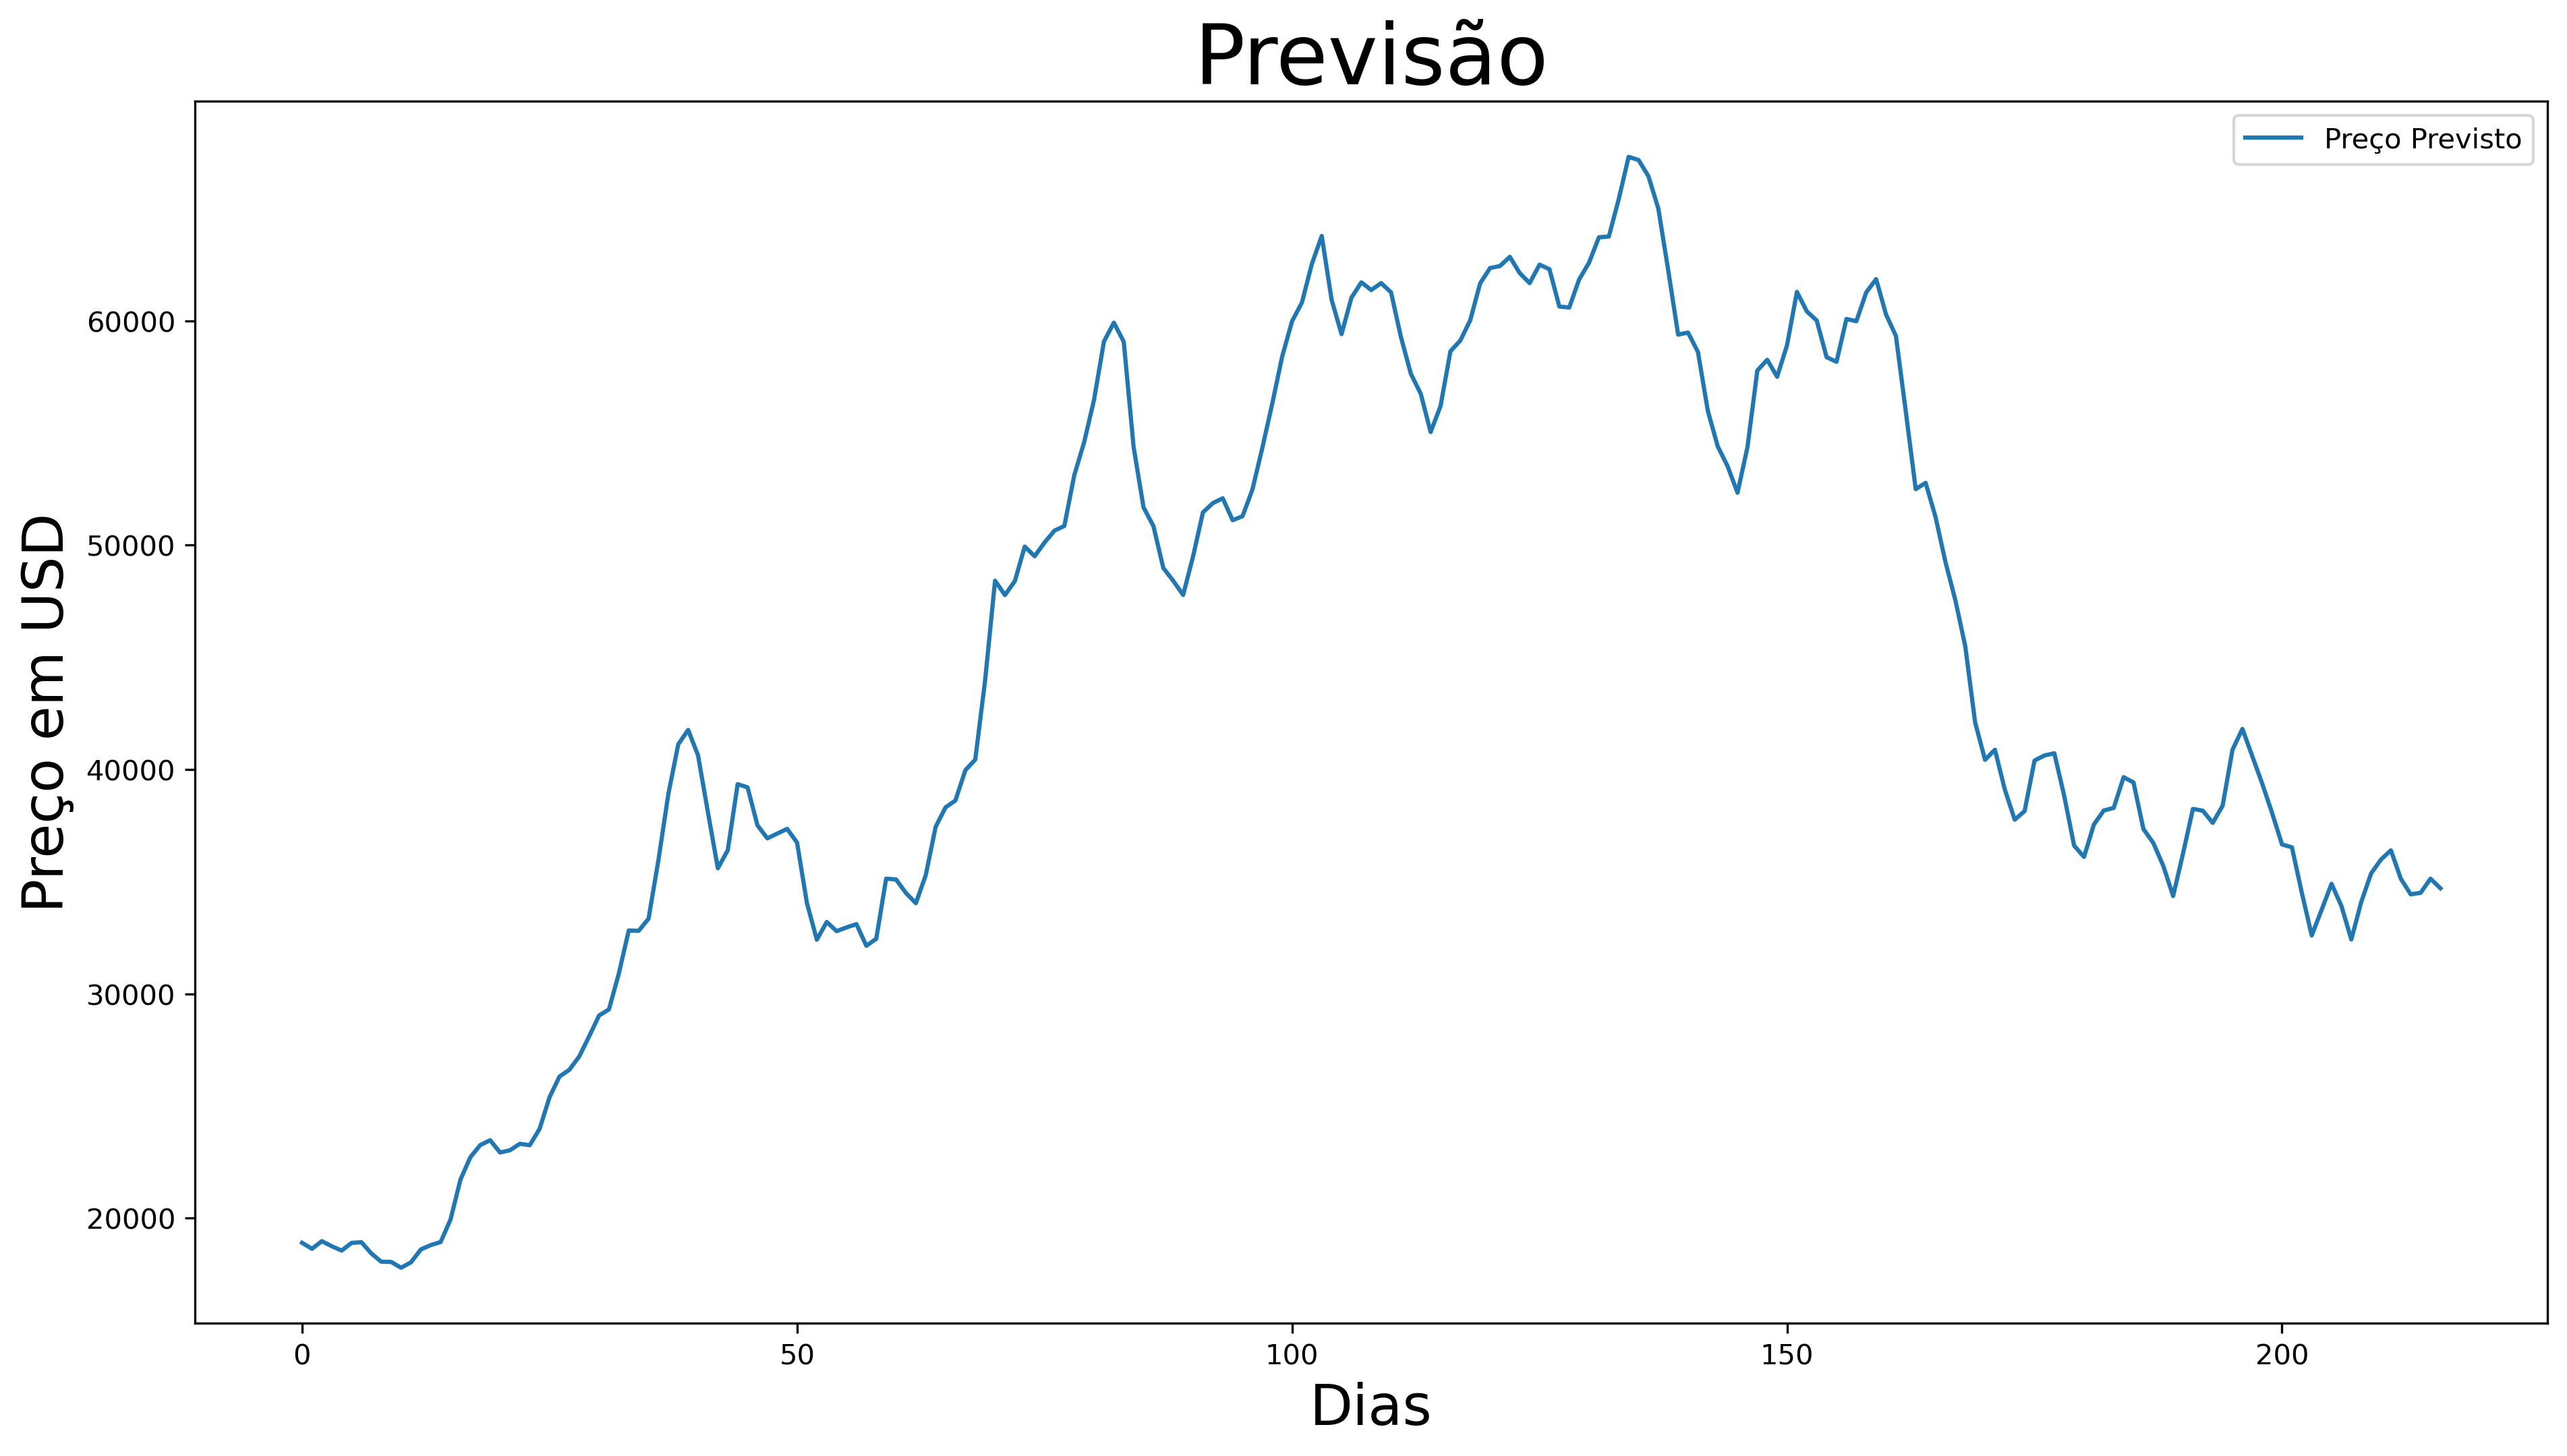

In [8]:
plt.figure(figsize=(15, 8), dpi=300, facecolor = 'w', edgecolor = 'k')

plt.plot(previsao_reescala[:, 0], label = 'Preço Previsto')

plt.title('Previsão', fontsize = 30)
plt.xlabel('Dias', fontsize=20)
plt.ylabel('Preço em USD', fontsize = 20)
plt.legend(loc = 'best')
plt.show()

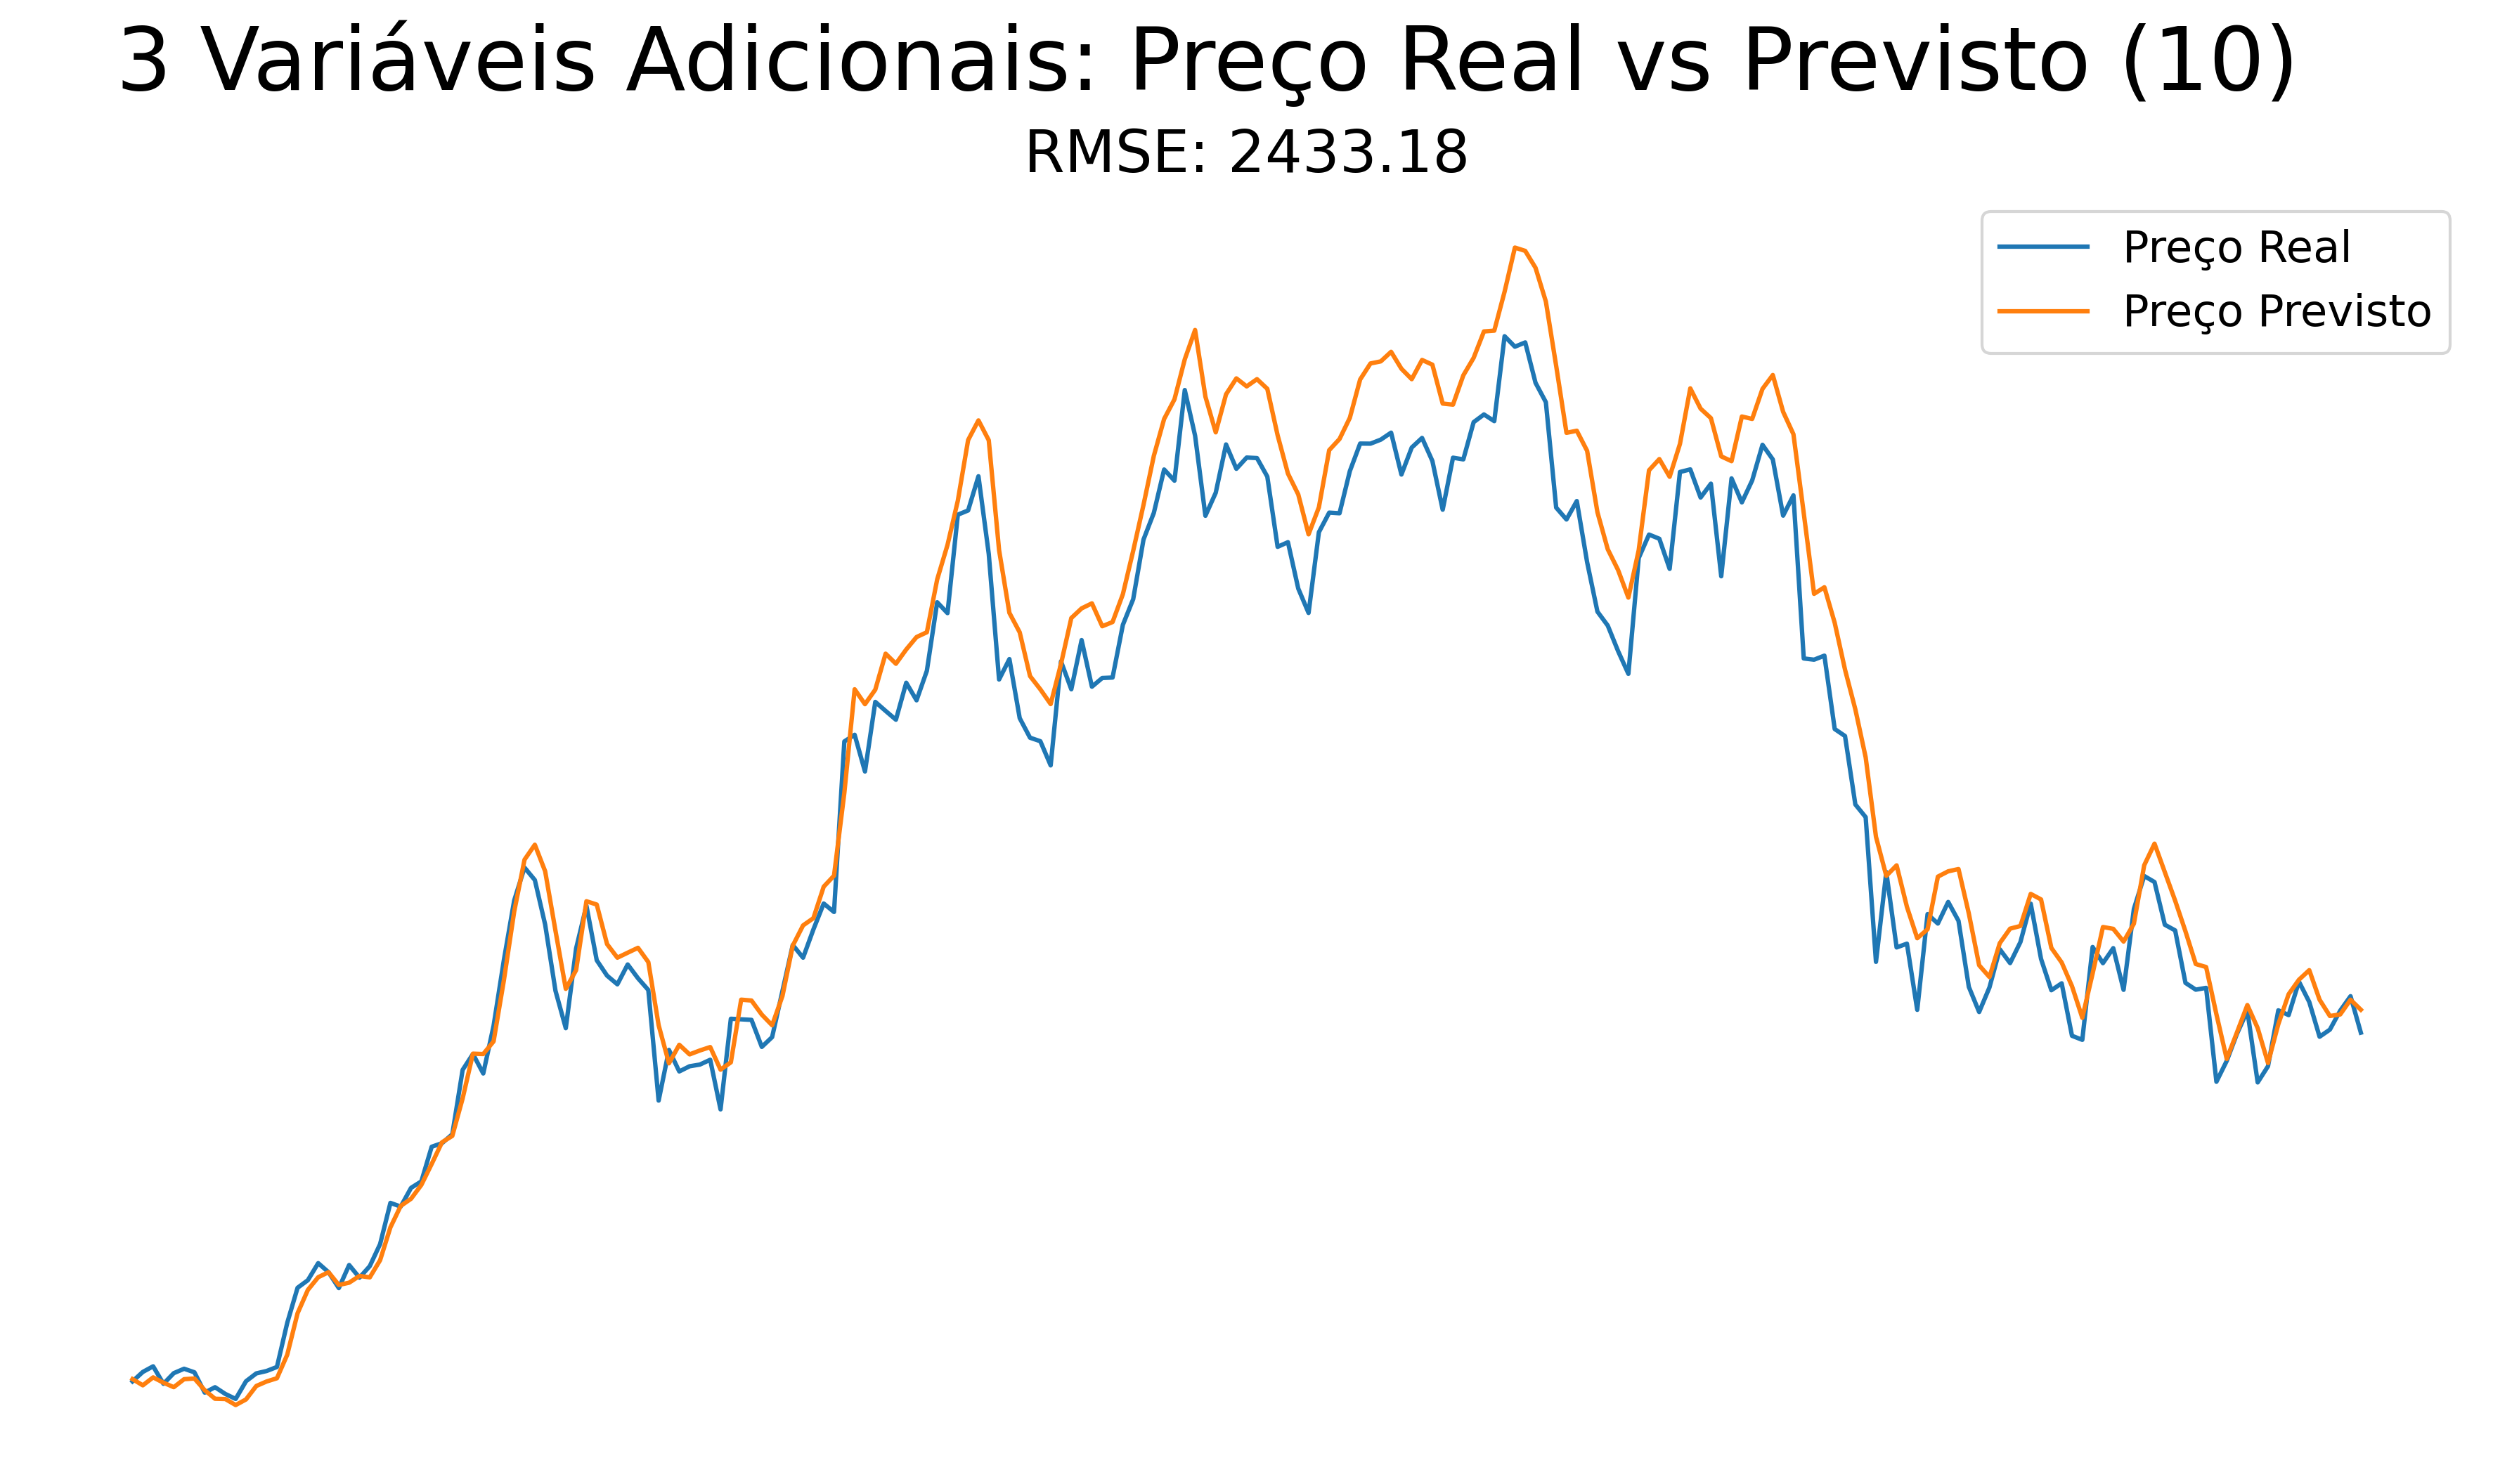

In [9]:
# grafico previsão vs real
plt.figure(figsize=(15, 8), dpi=300, facecolor = 'w', edgecolor = 'k')

plt.plot(teste_reescala[:, 0], label = 'Preço Real')
plt.plot(previsao_reescala[:, 0], label='Preço Previsto')

plt.suptitle('3 Variáveis Adicionais: Preço Real vs Previsto ('+n+')', fontsize = 30)
plt.title('RMSE: %.2f' % rmse, fontsize=20)
#plt.xlabel('Dias', fontsize=20)
#plt.ylabel('Preço em USD', fontsize = 20)
plt.axis('off')
plt.legend(loc = 'best', fontsize=15)
plt.savefig(figname+'-graf.png', bbox_inches='tight')
plt.show()